# A Friendly Guide on the Basics of the Phase-Based Motion Magnification

**Aral Sarrafi$^a$\*, Zhu Mao$^a$\*\***

$^a$ Department of Mechanical Engineering, University of Massachusetts Lowell

\* aral_sarrafi@uml.edu

\*\* zhu_mao@uml.edu

www.uml.edu/SDASL

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generating-a-simulated-video" data-toc-modified-id="Generating-a-simulated-video-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating a simulated video</a></span></li><li><span><a href="#Motion-Magnification-Without-filtering" data-toc-modified-id="Motion-Magnification-Without-filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Motion Magnification Without filtering</a></span></li><li><span><a href="#Motion-Magnification-With-Filtering" data-toc-modified-id="Motion-Magnification-With-Filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Motion Magnification With Filtering</a></span><ul class="toc-item"><li><span><a href="#Filtering" data-toc-modified-id="Filtering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Motion-Magnification-with-Filtering-Algorithm" data-toc-modified-id="Motion-Magnification-with-Filtering-Algorithm-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Motion Magnification with Filtering Algorithm</a></span></li></ul></li><li><span><a href="#Final-Remarks" data-toc-modified-id="Final-Remarks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final Remarks</a></span></li></ul></div>

This notebook is a simple tutorial aimed to provide a basic understanding of the phase-based video processing methodology.

**Note:** The material in this notebook is designed for processing simple computer generated videos with a global motion to provide basic intuitions about the phase-based video processing procedure and cannot not be used to process real videos captured with cameras that have local motions in them.

**Note:** The Flowing libraries are required to be setup for the notebook to operate correctly:

**1- numpy**

**2- math**

**3- matplotlib**

**4- scipy**

All the required libraries are imported in the following cell.

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal

%matplotlib notebook

## Generating a simulated video

For the entire tutorial simulated videos are required to demonstrate the procedure of Phase-Based Video Processing.
A 2D Gaussian function is used to generate the simulated videos. The Following function generates a single 2D Gaussian surface. By applying motion to this Gaussian surface, a simulated video can be obtained.


In [2]:
"""This function creats a 2D gaussian surface, we will be using this gaussian surfaces to creat the frame of our virtual video.""" 
def Gaussian(x0, y0, sigmax, sigmay, theta):
    imagelb = -15
    imageup = 15

    n_pixels = 512

    [X,Y] = np.meshgrid(np.linspace(imagelb,imageup,n_pixels),np.linspace(imagelb,imageup,n_pixels))

    A = 1

    a = cos(theta)**2/(2*sigmax**2) + sin(theta)**2/(2*sigmay**2)
    b = -sin(2*theta)/(4*sigmax**2) + sin(2*theta)/(4*sigmay**2)
    c = sin(theta)**2/(2*sigmax**2) + cos(theta)**2/(2*sigmay**2)


    Z = A*np.exp(-(a*np.power(X-x0,2) - 2*b*(X-x0)*(Y-y0) + c*np.power(Y-y0,2)))
    
    return Z

Text(0, 0.5, 'y')

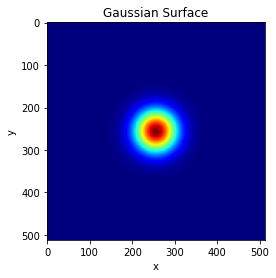

In [3]:
frame = Gaussian(0, 0, 2, 2, 0)

plt.figure()
plt.imshow(frame, cmap ='jet')
plt.title('Gaussian Surface')
plt.xlabel('x')
plt.ylabel('y')

Now by applying motion to this Gaussian surface a simulated video can be obtained. The following function gets a motion vector and outputs a simulated video based on this motion vector.

In [4]:
def generate_video(motion):
    video = []
    
    for dx in motion:
        
        frame = Gaussian(dx, 0, 2, 2, 0)
        video.append(frame)
    
    return np.array(video)

In [5]:
motion = []

total_time = 3
dt = 100
time = np.linspace(0, total_time, dt)


freq = 5
Amp = 1

motion = Amp * np.sin(2* np.pi * freq * time)

In [6]:
video = generate_video(motion)

In [7]:
'''This Cell animates the created video in the previous cell'''

%matplotlib notebook

fig = plt.figure()

ims = []

for i in range(len(video)):
    
    im = plt.imshow(video[i],cmap = 'jet',animated = True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1)


<IPython.core.display.Javascript object>

## Motion Magnification Without filtering

The following function is an implementation of the phase-based motion magnification using the fast Fourier transformation (FFT).

This function has the following architecture.

1) All frames are mapped to a complex number using FFT

2) The phase of the complex numbers is computed.

3) The phase difference between the first frame and all the other frames are obtained.

4) The phase difference is multiplied by a magnification factor (alpha).

5) The magnified phased are added to the phase for the first frame.

6) A new set of complex representation of the video is created with the phase planes from step 5.

7) Inverse Fourier transformation is used to reconstruct the motion-magnified video.


In [8]:
def Phase_Based_Motion_Magnification(video, alpha):
    
    magnified_video = []
    
    frame0 = video[0,:,:]
    
    magnified_video.append(frame0)
    
    C0 = np.fft.fft2(frame0)
    
    
    Amp0 = np.absolute(C0)
    
    Phase0 = np.angle(C0)
    

    
    for i in range(1, len(video)):
        
        frame1 = video[i,:,:]
    
        C1 = np.fft.fft2(frame1)
        
        Amp1 = np.absolute(C1)
        
        Phase1 = np.angle(C1)
        
        Phase_difference = Phase1 - Phase0
        
        magnified_Phase = Phase0 + alpha * Phase_difference
        
        x = Amp1 * np.cos(magnified_Phase)
        y = Amp1 * np.sin(magnified_Phase)
    
        magnified_C1 = x + 1j*y
        
        
        magnified_frame = np.real(np.fft.ifft2(magnified_C1))
        
        magnified_video.append(magnified_frame)
    
    return magnified_video

In [9]:
# Let's Creat our first motion-magnified video
mag_video = Phase_Based_Motion_Magnification(video, 10)

In [10]:
# Animate the motion-magnified video
fig = plt.figure(2)

mag_ims = []

for i in range(len(mag_video)):
    
    im = plt.imshow(mag_video[i],cmap = 'jet',animated = True)
    mag_ims.append([im])

ani = animation.ArtistAnimation(fig, mag_ims, interval=100, blit=True, repeat_delay=1)

<IPython.core.display.Javascript object>

In [11]:
'''This cell animates both the original video and motion magnified video next to each other for better comparison'''

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 6))

original = ax1.imshow(video[0], cmap = 'jet')
ax1.set_title('Original Video')

magnified = ax2.imshow(mag_video[0], cmap = 'jet')
ax2.set_title('Motion Magnified Video')



def animate(s):
    
    original.set_array(video[s])
    magnified.set_array(mag_video[s])
    

def init():
    original.set_title("Original Video")
    magnified.set_title("Motion Magnified Video")
    
    return original, magnified,

steps = [i for i in range(len(video))]
ani = animation.FuncAnimation(fig1, animate, steps, interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>

## Motion Magnification With Filtering

In the next set of simulation, we will generate a video with a motion, which contains two frequencies. The objective is to generate a motion-magnified video, which represents only the motion for one of the frequencies. This procedure is necessary for application in structural dynamics identification applications. Having a motion-magnified video with an isolated frequency will reveal the operating deflection shape of the structure for the selected frequency, which will be presented later after the tutorial.

The following cell will generate a motion vector with two frequencies.


In [12]:
freq0 = 5
freq1 = 12

amp1 = 1
amp2 = 1

total_time = 2

Fs = 100
Ts = 1/Fs

n = int(total_time/Ts)

time = np.linspace(0,total_time, n)
pi = np.pi


x =amp1 * np.sin(2 * pi * freq0 *time) + amp2 * np.sin(2 * pi * freq1 *time)

plt.figure(3)
plt.plot(time, x)
plt.title('original signal')
plt.xlabel('time(s)')
plt.ylabel('x(t)')
plt.show()

### Filtering

For the motion magnification with filtering, we will need a band pass filter to filter the phase variations (phase differences) to obtain the new set of phase plans. The following cell demonstrates the filter design and its performance on out motion.


In [13]:
fn = Fs/2

band_width = 1

wl = (freq0 - band_width)/fn
wh = (freq0 + band_width)/fn

b, a = signal.butter(2, [wl, wh], 'bandpass')
w, h = signal.freqz(b, a)

plt.figure(2)
plt.plot(w, 20 * np.log10(abs(h)))
#plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

c:\Users\slavic\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


### Motion Magnification with Filtering Algorithm

The following function is an implementation of the phase-based motion magnification using the fast Fourier transformation (FFT).

This function has following architecture.

1) All frames are mapped to a complex numbers using FFT

2) The phase of the complex numbers are computed.

3) The phase difference between the first frame and all the other frames are obtained, and stored in the memory.

4) The phase difference **is filtered with a band pass filter**, and then multiplied by a magnification factor (alpha).

5) The **filtered and magnified phases** are added to the phase for the first frame.

6) A set of new complex representation of the video is created with the phase planes from step 5.

7) Inverse Fourier transformation is used to reconstruct the motion-magnified video.

In [14]:
def PMM_with_Filtering(video, alpha, f, Fs):
    
    magnified_video = []
    
    PHASE = []
    AMP = []
    
    
    frame0 = video[0,:,:]
    
    magnified_video.append(frame0)
    
    C0 = np.fft.fft2(frame0)
    
    Phase0 = np.angle(C0)
    
    PHASE.append(Phase0)
    
    
    # Computer the Phase and amplitude for all the frames:
    
    for i in range(1, len(video)):
        
        frame1 = video[i,:,:]
    
        C1 = np.fft.fft2(frame1)
        
        Phase1 = np.angle(C1)
        PHASE.append(Phase1)
        
        
        Amp1 = np.absolute(C1)
        AMP.append(Amp1)
        
    AMP = np.array(AMP)    
    PHASE = np.array(PHASE)
    # Unwarp the phase values
    PHASE = np.unwrap(PHASE, axis = 0)
    
    PHASE_diff = []
    
    for i in range(1, len(video)):
        
        delta_Phi = PHASE[i,:,:] - PHASE[0,:,:]
        
        PHASE_diff.append(delta_Phi)
    
    
    PHASE_diff = np.array(PHASE_diff)
    
    
    # Filter the Phase differences
    fn = Fs/2

    wl = (f - 2)/fn
    wh = (f + 2)/fn

    b, a = signal.butter(4, [wl, wh], 'bandpass')
    
    filtered_phase = alpha * signal.lfilter(b,a, PHASE_diff, axis = 0)
    
    
    
    for i in range(0, len(video)-1):
        
        x = AMP[i,:,:] * np.cos(Phase0 + filtered_phase[i,:,:])
        y = AMP[i,:,:] * np.sin(Phase0 + filtered_phase[i,:,:])
    
        magnified_C1 = x + 1j*y
        
        
        magnified_frame = np.real(np.fft.ifft2(magnified_C1))
        
        magnified_video.append(magnified_frame)
        
    
    return magnified_video

In [15]:
f0 = 5
f1 = 12
total_time = 2

Fs = 100
Ts = 1/Fs

n = int(total_time/Ts)

time = np.linspace(0,total_time, n)
pi = np.pi

motion = np.sin(2 * pi * f0 *time) + np.sin(2 * pi * f1 *time)

plt.figure(1)
plt.plot(time, motion)
plt.title('Motion')
plt.xlabel('time(s)')
plt.show()


In [16]:
# Generate a new video with the new motion that contains two frequencies
video = generate_video(motion)

In [17]:
# Animate the original video

fig = plt.figure()

ims = []

for i in range(len(video)):
    
    im = plt.imshow(video[i],cmap = 'jet',animated = True)
    plt.title('Original Video')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1)

<IPython.core.display.Javascript object>

In [18]:
# Apply the phase-based motion magnification with filtering, to get a motion magnified-video with a specific frequency.

mag_video = PMM_with_Filtering(video, 3, f0, Fs)

In [19]:
# Animate the motion magnified video
fig = plt.figure()

ims = []

for i in range(len(mag_video)):
    
    im = plt.imshow(mag_video[i],cmap = 'jet',animated = True)
    plt.title('Motion Magnified Video with Filtering')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1)

<IPython.core.display.Javascript object>

In [20]:
'''This cell animates both the original video and motion magnified video next to each other for better comparison'''

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 6))

original = ax1.imshow(video[0], cmap = 'jet')
ax1.set_title('Original Video')

magnified = ax2.imshow(mag_video[0], cmap = 'jet')
ax2.set_title('Motion Magnified Video with Filtering')



def animate(s):
    
    original.set_array(video[s])
    magnified.set_array(mag_video[s])
    

    
    return original, magnified,

steps = [i for i in range(len(video))]
ani = animation.FuncAnimation(fig1, animate, steps, interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [21]:
# Why the first couple of frames of the motion magnified video has smaller motion
y = signal.lfilter(b,a,motion)

plt.figure(6)
plt.plot(time, y)
plt.title('Filtered signal')
plt.xlabel('time(s)')
plt.ylabel('signal')
plt.show()

## Final Remarks

1) This set of simulations are only designed for videos with global motion.

2) For videos with local motion this set of simulation **is not applicable**.

3) The basis functions of the Fourier transformation are sinusoid, which have infinite spatial domain. Therefore, Fourier transformation will fail to process the videos with local motions.

4) In order to process videos with local motions, Gabor wavelets should be used. Gabor wavelets are sinusoids that are windowed by a Gaussian envelope.

5) Gabor wavelets or other steerable filters have finite spatial domain, and they can process local motions as well.

6) The implementation of the phase-based-motion magnification with steerable filters is available at (http://people.csail.mit.edu/mrub/vidmag/#code).

